In [21]:
import pandas as pd
import os, sys 
sys.path.append(os.getcwd()[:-9])  # add repo root to path
from utils import get_repo_root

import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import TomekLinks


In [2]:
repo_root = get_repo_root()

In [41]:
input_set = pd.read_csv(str(repo_root) + '/data/features_all.csv')
ref_test = pd.read_csv(str(repo_root) + '/data/referance_data_test.csv')
ref = pd.read_csv(str(repo_root) + '/data/referance_data.csv')

In [42]:
input_set.head()

,cust_id,ref_date,mobile_eft_all_cnt_l0m,mobile_eft_all_cnt_l2m,mobile_eft_all_cnt_l5m,mobile_eft_all_cnt_l8m,mobile_eft_all_cnt_l1year,mobile_eft_all_cnt_l2years,mobile_eft_all_cnt_l4years,active_product_category_nbr_l0m,...,province_GRO,province_LIM,province_NOB,province_NOH,province_OVE,province_UTR,province_ZEE,province_ZUI,age_bin,tenure_bin
0,0,2017-09-01,1.0,4.0,7.0,5.0,13.0,17.0,0.0,2.0,...,0,0,0,1,0,0,0,0,9,2
1,1,2019-02-01,0.0,1.0,8.0,3.0,4.0,23.0,22.0,3.0,...,0,0,0,0,0,0,0,1,7,1
2,2,2019-01-01,1.0,5.0,7.0,3.0,5.0,32.0,34.0,3.0,...,0,0,1,0,0,0,0,0,8,4
3,3,2018-10-01,2.0,2.0,3.0,6.0,9.0,16.0,19.0,3.0,...,0,0,0,0,0,0,0,1,0,0
4,5,2018-03-01,4.0,9.0,10.0,10.0,14.0,17.0,5.0,2.0,...,0,0,0,0,0,0,0,1,1,2


In [75]:
input_set_with_labels = input_set.merge(ref, on=['cust_id', 'ref_date'], how='left')


In [76]:
test_data

,cust_id,ref_date,mobile_eft_all_cnt_l0m,mobile_eft_all_cnt_l2m,mobile_eft_all_cnt_l5m,mobile_eft_all_cnt_l8m,mobile_eft_all_cnt_l1year,mobile_eft_all_cnt_l2years,mobile_eft_all_cnt_l4years,active_product_category_nbr_l0m,...,province_LIM,province_NOB,province_NOH,province_OVE,province_UTR,province_ZEE,province_ZUI,age_bin,tenure_bin,churn
1,1,2019-02-01,0.0,1.0,8.0,3.0,4.0,23.0,22.0,3.0,...,0,0,0,0,0,0,1,7,1,NaN
2,2,2019-01-01,1.0,5.0,7.0,3.0,5.0,32.0,34.0,3.0,...,0,1,0,0,0,0,0,8,4,NaN
8,9,2019-03-01,1.0,3.0,6.0,5.0,6.0,33.0,76.0,2.0,...,0,0,0,0,0,0,0,6,4,NaN
14,15,2019-06-01,0.0,1.0,3.0,6.0,11.0,32.0,30.0,3.0,...,1,0,0,0,0,0,0,8,1,NaN
18,19,2019-01-01,1.0,2.0,5.0,6.0,7.0,29.0,25.0,3.0,...,0,1,0,0,0,0,0,7,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176248,199951,2019-03-01,4.0,5.0,10.0,4.0,12.0,26.0,26.0,3.0,...,0,0,0,0,0,0,1,1,0,NaN
176249,199952,2019-05-01,1.0,2.0,3.0,0.0,0.0,17.0,10.0,3.0,...,0,0,1,0,0,0,0,3,4,NaN
176260,199963,2019-05-01,5.0,11.0,19.0,19.0,5.0,66.0,148.0,2.0,...,1,0,0,0,0,0,0,7,4,NaN
176261,199964,2019-03-01,5.0,6.0,12.0,7.0,5.0,16.0,19.0,3.0,...,0,0,0,0,0,1,0,6,1,NaN


In [77]:
input_set_with_labels = pd.get_dummies(input_set_with_labels, columns=['age_bin', 'tenure_bin', 'month', 'quarter'], drop_first=True)

In [78]:
training_data = input_set_with_labels[input_set_with_labels['churn'].notna()]
test_data = input_set_with_labels[input_set_with_labels['churn'].isna()]

/Users/yasin.secal/Desktop/yasins/ing_hubs/ing-datathon-team-guney-kampus/venv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5405: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


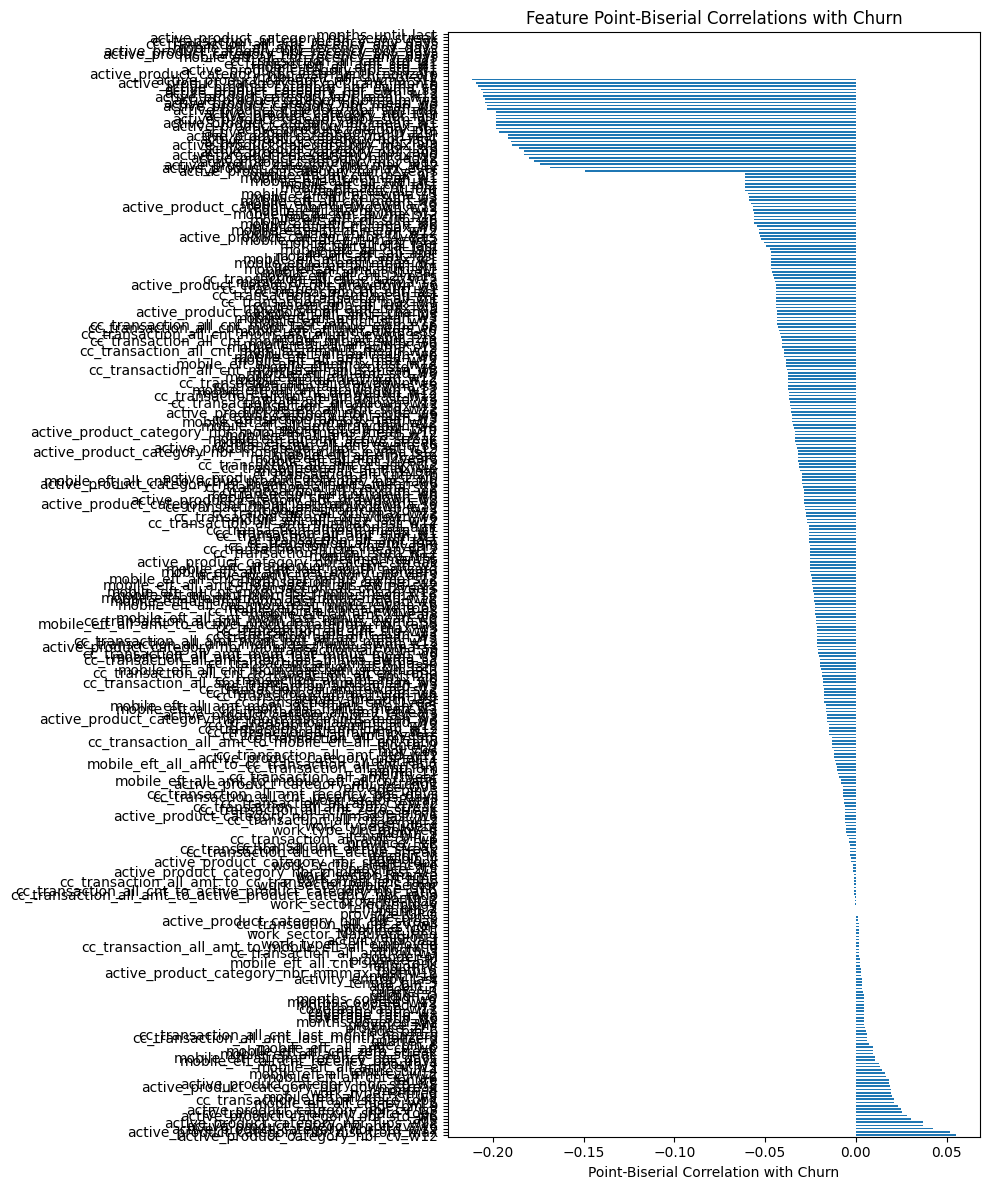

In [67]:
from scipy.stats import pointbiserialr

# Calculate point-biserial correlations with churn column
pb_correlations = {}
feature_cols = training_data.drop(['cust_id', 'ref_date','date', 'churn'], axis=1).columns

for col in feature_cols:
    corr, _ = pointbiserialr(training_data['churn'], training_data[col])
    pb_correlations[col] = corr

# Convert to Series and sort
pb_corr_series = pd.Series(pb_correlations).sort_values(ascending=False)

# Plot the correlations
plt.figure(figsize=(10, 12))
pb_corr_series.plot(kind='barh')
plt.xlabel('Point-Biserial Correlation with Churn')
plt.title('Feature Point-Biserial Correlations with Churn')
plt.tight_layout()
plt.show()

In [69]:
pb_corr_series.dropna().head(20)

active_product_category_nbr_cv_w12           0.055021
active_product_category_nbr_dist_from_max    0.051868
active_product_category_nbr_std_w12          0.042441
active_product_category_nbr_cv_w6            0.037217
active_product_category_nbr_flips_w12        0.037089
age                                          0.030268
active_product_category_nbr_std_w6           0.028319
cc_transaction_all_cnt_share_topk            0.025306
active_product_category_nbr_cv_w3            0.024598
age_bin_9                                    0.023140
mobile_eft_all_cnt_cv_w12                    0.021252
cc_transaction_all_amt_share_topk            0.020706
mobile_eft_all_cnt_cv_w3                     0.019970
work_type_Retired                            0.019581
month_8                                      0.019468
active_product_category_nbr_down_streak      0.019050
active_product_category_nbr_std_w3           0.018448
tenure                                       0.018389
mobile_eft_all_cnt_cv_w6    

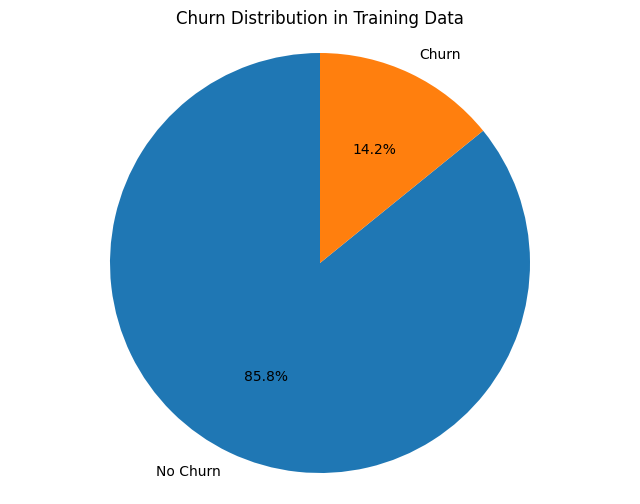

In [47]:
import matplotlib.pyplot as plt

# Count the values in churn column
churn_counts = training_data['churn'].value_counts()

# Create pie chart
plt.figure(figsize=(8, 6))
plt.pie(churn_counts, labels=['No Churn', 'Churn'], autopct='%1.1f%%', startangle=90)
plt.title('Churn Distribution in Training Data')
plt.axis('equal')
plt.show()

## MODELLING

In [11]:
from utils.ml_functions import ing_hubs_datathon_metric 
from utils.ml_functions import OptunaTuner

In [12]:
training_data['date']

0         2017-09-01
3         2018-10-01
4         2018-03-01
5         2018-04-01
6         2018-05-01
             ...    
176288    2018-09-01
176289    2018-06-01
176290    2018-12-01
176291    2018-02-01
176292    2018-06-01
Name: date, Length: 133287, dtype: object

In [13]:
training_data.iloc[:, 2:-1]

,mobile_eft_all_cnt_l0m,mobile_eft_all_cnt_l2m,mobile_eft_all_cnt_l5m,mobile_eft_all_cnt_l8m,mobile_eft_all_cnt_l1year,mobile_eft_all_cnt_l2years,mobile_eft_all_cnt_l4years,active_product_category_nbr_l0m,active_product_category_nbr_l2m,active_product_category_nbr_l5m,...,cc_transaction_all_cnt_to_active_product_category_nbr_ratio,mobile_eft_all_cnt_to_active_product_category_nbr_ratio,months_since_first,months_until_last,lifetime_months,month,quarter,moy_sin,moy_cos,is_q_end
0,1.0,4.0,7.0,5.0,13.0,17.0,0.0,2.0,4.0,6.0,...,0.000000,0.500000,20,0,21,9,3,-1.000000e+00,-1.836970e-16,1
3,2.0,2.0,3.0,6.0,9.0,16.0,19.0,3.0,6.0,9.0,...,7.000000,0.666667,33,0,34,10,4,-8.660254e-01,5.000000e-01,0
4,4.0,9.0,10.0,10.0,14.0,17.0,5.0,2.0,4.0,6.0,...,1.500000,2.000000,26,0,27,3,1,1.000000e+00,6.123234e-17,1
5,6.0,12.0,13.0,13.0,17.0,102.0,37.0,2.0,4.0,7.0,...,0.500000,3.000000,27,0,28,4,2,8.660254e-01,-5.000000e-01,0
6,0.0,0.0,0.0,0.0,0.0,18.0,5.0,3.0,6.0,9.0,...,25.666667,0.000000,28,0,29,5,2,5.000000e-01,-8.660254e-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176288,5.0,11.0,10.0,3.0,4.0,3.0,10.0,3.0,6.0,9.0,...,1.333333,1.666667,32,0,33,9,3,-1.000000e+00,-1.836970e-16,1
176289,1.0,7.0,9.0,5.0,7.0,25.0,6.0,2.0,4.0,8.0,...,2.000000,0.500000,29,0,30,6,2,1.224647e-16,-1.000000e+00,1
176290,4.0,8.0,15.0,21.0,46.0,187.0,45.0,2.0,4.0,6.0,...,5.000000,2.000000,35,0,36,12,4,-2.449294e-16,1.000000e+00,1
176291,6.0,14.0,11.0,15.0,17.0,28.0,2.0,3.0,6.0,9.0,...,11.333333,2.000000,25,0,26,2,1,8.660254e-01,5.000000e-01,0


In [79]:
X = training_data.drop(['cust_id', 'ref_date','date', 'churn'], axis=1)
y = training_data['churn']

In [49]:
studies = {
     "None_XGBClassifier_LogLoss_INGHubsMetric": OptunaTuner(
        model_name="XGBoost",
        sampler=None,
        loss="binary:logistic",
        eval_metric="ing_hubs_datathon_metric",    # Used for CV scoring only
        n_trials=5,
        study_name="None_XGBClassifier_LogLoss_INGHubsMetric"
    ),
    "RandomOverSampler_XGBClassifier_LogLoss_INGHubsMetric": OptunaTuner(
        model_name="XGBoost",
        sampler="RandomOverSampler",
        loss="binary:logistic",
        eval_metric="ing_hubs_datathon_metric",    # Used for CV scoring only
        n_trials=5,
        study_name="RandomOverSampler_XGBClassifier_LogLoss_INGHubsMetric"
    ),
    "SMOTE_XGBClassifier_LogLoss_INGHubsMetric": OptunaTuner(
        model_name="XGBoost",
        sampler="SMOTE",
        loss="binary:logistic",
        eval_metric="ing_hubs_datathon_metric",    # Used for CV scoring only
        n_trials=5,
        study_name="SMOTE_XGBClassifier_LogLoss_INGHubsMetric"
    ),
    "SMOTE_RandomForestClassifier_LogLoss_INGHubsMetric": OptunaTuner(
        model_name="RandomForest",
        sampler="SMOTE",        
        eval_metric="ing_hubs_datathon_metric",    # Used for CV scoring only
        n_trials=5,
        study_name="SMOTE_RandomForestClassifier_LogLoss_INGHubsMetric"
    ),
    "SMOTE_Ensemble_LogLoss_INGHubsMetric": OptunaTuner(
        model_name="Ensemble",
        sampler="SMOTE",        
        eval_metric="ing_hubs_datathon_metric",    # Used for CV scoring only
        n_trials=5,
        study_name="SMOTE_Ensemble_LogLoss_INGHubsMetric"
    )
}

In [50]:
study1 = studies["None_XGBClassifier_LogLoss_INGHubsMetric"].optimize(X, y)

  0%|          | 0/5 [00:00<?, ?it/s]


Study Name: None_XGBClassifier_LogLoss_INGHubsMetric
  Train size: 106629, Val size: 26658
  Train class dist: [91533 15096]
  Val class dist: [22884  3774]
  Pred proba range: [0.0000, 0.9891]
  Pred labels dist: [23139  3519]
[I 2025-10-21 10:24:58] Trial 0 finished with value: 0.92 and parameters: {'n_estimators': 574, 'learning_rate': '0.23', 'max_depth': 8, 'min_child_weight': '0.63', 'subsample': '0.58', 'colsample_bytree': '0.58', 'gamma': '0.58', 'reg_alpha': '0.62', 'reg_lambda': '0.00', 'max_bin': 400}. Best is trial 0 with value: 0.92.
[I 2025-10-21 10:25:27] Trial 1 finished with value: 0.90 and parameters: {'n_estimators': 220, 'learning_rate': '0.25', 'max_depth': 9, 'min_child_weight': '0.04', 'subsample': '0.59', 'colsample_bytree': '0.59', 'gamma': '3.04', 'reg_alpha': '0.00', 'reg_lambda': '0.00', 'max_bin': 240}. Best is trial 0 with value: 0.92.
[I 2025-10-21 10:26:23] Trial 2 finished with value: 1.16 and parameters: {'n_estimators': 812, 'learning_rate': '0.00', 

In [42]:
study1.best_params

{'n_estimators': 574,
 'learning_rate': 0.22648248189516842,
 'max_depth': 8,
 'min_child_weight': 0.6251373574521749,
 'subsample': 0.5780093202212182,
 'colsample_bytree': 0.5779972601681014,
 'gamma': 0.5808361216819946,
 'reg_alpha': 0.6245760287469887,
 'reg_lambda': 0.002570603566117596,
 'max_bin': 400}

In [43]:
model = XGBClassifier(**study1.best_params)

In [44]:
model.fit(X, y)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.5779972601681014
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [51]:
study2 = studies["RandomOverSampler_XGBClassifier_LogLoss_INGHubsMetric"].optimize(X, y)

  0%|          | 0/5 [00:00<?, ?it/s]


Study Name: RandomOverSampler_XGBClassifier_LogLoss_INGHubsMetric
  Train size: 183066, Val size: 26658
  Train class dist: [91533 91533]
  Val class dist: [22884  3774]
  Pred proba range: [0.0000, 0.9639]
  Pred labels dist: [23887  2771]
[I 2025-10-21 10:28:40] Trial 0 finished with value: 0.94 and parameters: {'n_estimators': 574, 'learning_rate': '0.23', 'max_depth': 8, 'min_child_weight': '0.63', 'subsample': '0.58', 'colsample_bytree': '0.58', 'gamma': '0.58', 'reg_alpha': '0.62', 'reg_lambda': '0.00', 'max_bin': 400}. Best is trial 0 with value: 0.94.
[I 2025-10-21 10:29:09] Trial 1 finished with value: 0.94 and parameters: {'n_estimators': 220, 'learning_rate': '0.25', 'max_depth': 9, 'min_child_weight': '0.04', 'subsample': '0.59', 'colsample_bytree': '0.59', 'gamma': '3.04', 'reg_alpha': '0.00', 'reg_lambda': '0.00', 'max_bin': 240}. Best is trial 1 with value: 0.94.
[I 2025-10-21 10:30:30] Trial 2 finished with value: 1.17 and parameters: {'n_estimators': 812, 'learning_ra

In [71]:
study3 = studies["SMOTE_XGBClassifier_LogLoss_INGHubsMetric"].optimize(X, y)

  0%|          | 0/5 [00:00<?, ?it/s]


Study Name: SMOTE_XGBClassifier_LogLoss_INGHubsMetric
  Train size: 183066, Val size: 26658
  Train class dist: [91533 91533]
  Val class dist: [22884  3774]
  Pred proba range: [0.0045, 0.6561]
  Pred labels dist: [26614    44]
[I 2025-10-21 10:44:19] Trial 0 finished with value: 1.10 and parameters: {'n_estimators': 574, 'learning_rate': '0.23', 'max_depth': 8, 'min_child_weight': '0.63', 'subsample': '0.58', 'colsample_bytree': '0.58', 'gamma': '0.58', 'reg_alpha': '0.62', 'reg_lambda': '0.00', 'max_bin': 400}. Best is trial 0 with value: 1.10.
[I 2025-10-21 10:44:44] Trial 1 finished with value: 1.05 and parameters: {'n_estimators': 220, 'learning_rate': '0.25', 'max_depth': 9, 'min_child_weight': '0.04', 'subsample': '0.59', 'colsample_bytree': '0.59', 'gamma': '3.04', 'reg_alpha': '0.00', 'reg_lambda': '0.00', 'max_bin': 240}. Best is trial 0 with value: 1.10.
[I 2025-10-21 10:46:25] Trial 2 finished with value: 1.07 and parameters: {'n_estimators': 812, 'learning_rate': '0.00',

In [86]:
study4 = studies["SMOTE_Ensemble_LogLoss_INGHubsMetric"].optimize(X, y)

  0%|          | 0/5 [00:00<?, ?it/s]


Study Name: SMOTE_Ensemble_LogLoss_INGHubsMetric
  Train size: 183066, Val size: 26658
  Train class dist: [91533 91533]
  Val class dist: [22884  3774]
  Pred proba range: [0.0348, 0.5216]
  Pred labels dist: [26654     4]
[I 2025-10-21 11:19:24] Trial 0 finished with value: 1.12 and parameters: {'weight_xgb': '0.37', 'weight_rf': '0.95', 'weight_cat': '0.73', 'xgb_n_estimators': 799, 'xgb_learning_rate': '0.00', 'xgb_max_depth': 4, 'xgb_subsample': '0.53', 'xgb_colsample_bytree': '0.93', 'rf_n_estimators': 681, 'rf_max_depth': 22, 'rf_min_samples_split': 2, 'rf_max_features': 'sqrt', 'cat_iterations': 518, 'cat_learning_rate': '0.00', 'cat_depth': 6, 'cat_l2_leaf_reg': '5.72'}. Best is trial 0 with value: 1.12.
[W 2025-10-21 11:28:27,904] Trial 1 failed with parameters: {'weight_xgb': 0.43194501864211576, 'weight_rf': 0.2912291401980419, 'weight_cat': 0.6118528947223795, 'xgb_n_estimators': 339, 'xgb_learning_rate': 0.005292705365436975, 'xgb_max_depth': 5, 'xgb_subsample': 0.728034

KeyboardInterrupt: 

In [18]:
study4.best_params

NameError: name 'study4' is not defined

[I 2025-10-21 00:52:59] Trial 0 finished with value: 1.11 and parameters: {'weight_xgb': '0.37', 'weight_rf': '0.95', 'weight_cat': '0.73', 'xgb_n_estimators': 799, 'xgb_learning_rate': '0.00', 'xgb_max_depth': 4, 'xgb_subsample': '0.53', 'xgb_colsample_bytree': '0.93', 'rf_n_estimators': 681, 'rf_max_depth': 22, 'rf_min_samples_split': 2, 'rf_max_features': 'sqrt', 'cat_iterations': 518, 'cat_learning_rate': '0.00', 'cat_depth': 6, 'cat_l2_leaf_reg': '5.72'}. Best is trial 0 with value: 1.11.

In [19]:
params = {'weight_xgb': '0.37', 'weight_rf': '0.95', 'weight_cat': '0.73', 'xgb_n_estimators': 799, 'xgb_learning_rate': '0.00', 'xgb_max_depth': 4, 'xgb_subsample': '0.53', 'xgb_colsample_bytree': '0.93', 'rf_n_estimators': 681, 'rf_max_depth': 22, 'rf_min_samples_split': 2, 'rf_max_features': 'sqrt', 'cat_iterations': 518, 'cat_learning_rate': '0.00', 'cat_depth': 6, 'cat_l2_leaf_reg': '5.72'}

In [ ]:

model = XGBClassifier(**study3.best_params)
model.fit(X, y)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8925879806965068
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [84]:
X.fillna(0, inplace=True)

In [80]:
X_test = test_data.drop(['cust_id', 'ref_date','date', 'churn'], axis=1)

In [81]:
# Get best parameters from study3
best_params = study3.best_params

# Get the tuner object for study3
tuner = studies["None_XGBClassifier_LogLoss_INGHubsMetric"]

# Apply SMOTE resampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create and train XGBoost model with best parameters
model = XGBClassifier(**best_params, random_state=42)
model.fit(X_resampled, y_resampled)

# Prepare test data features
# Make predictions on test data
test_predictions = model.predict_proba(X_test)[:, 1]

# Create submission dataframe
submission = ref_test.copy()
submission['churn'] = test_predictions

print(f"Best parameters: {best_params}")
print(f"Predictions shape: {test_predictions.shape}")
print(submission.head())

Best parameters: {'n_estimators': 574, 'learning_rate': 0.22648248189516842, 'max_depth': 8, 'min_child_weight': 0.6251373574521749, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'gamma': 0.5808361216819946, 'reg_alpha': 0.6245760287469887, 'reg_lambda': 0.002570603566117596, 'max_bin': 400}
Predictions shape: (43006,)
   cust_id    ref_date     churn
0        1  2019-02-01  0.092649
1        2  2019-01-01  0.005366
2        9  2019-03-01  0.305116
3       15  2019-06-01  0.075479
4       19  2019-01-01  0.061838


In [87]:
from __future__ import annotations
from typing import Dict, Tuple, Optional, Any
import numpy as np

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

def _to_float(p, key, default=None, *, min_val=None, max_val=None, eps=None):
    v = p.get(key, default)
    if v is None:
        raise KeyError(f"Missing required float param: {key}")
    try:
        v = float(v)
    except Exception as e:
        raise ValueError(f"Param {key} must be float-like, got {v!r}") from e
    if eps is not None and abs(v) <= 0:
        v = eps
    if min_val is not None:
        v = max(min_val, v)
    if max_val is not None:
        v = min(max_val, v)
    return v

def _to_int(p, key, default=None, *, min_val=None, max_val=None):
    v = p.get(key, default)
    if v is None:
        raise KeyError(f"Missing required int param: {key}")
    try:
        v = int(v)
    except Exception as e:
        raise ValueError(f"Param {key} must be int-like, got {v!r}") from e
    if min_val is not None:
        v = max(min_val, v)
    if max_val is not None:
        v = min(max_val, v)
    return v

def _to_weight(p, key, default=1.0):
    v = p.get(key, default)
    try:
        return float(v)
    except Exception as e:
        raise ValueError(f"Blend weight {key} must be float-like, got {v!r}") from e

def _to_rf_max_features(v):
    if v in (None, "None"):
        return None
    if isinstance(v, str):
        v_lower = v.lower()
        if v_lower in {"sqrt", "log2"}:
            return v_lower
        try:
            if "." in v_lower:
                return float(v_lower)
            return int(v_lower)
        except:
            raise ValueError(f"rf_max_features not understood: {v!r}")
    return v


def fit_weighted_ensemble_sanitized(
    X_tr,
    y_tr,
    X_va,
    params: Dict[str, Any],
    *,
    use_gpu: bool = False,
    loss: Optional[str] = None,           # XGB: "binary:logistic"; Cat: "Logloss"; RF: "gini"/"entropy"/"log_loss"
    class_weights: Tuple[float, float] = (0.5, 0.5),
    sampler: Optional[Any] = None,        # keep for API compatibility; not used when SMOTE is on
    random_state: int = 42,
    sample_weight: Optional[np.ndarray] = None,
    threshold: float = 0.5,
    return_models: bool = False,
    use_smote: bool = True,
    smote_params: Optional[Dict[str, Any]] = None
):
    """
    Trains XGB + RF + CatBoost, with optional SMOTE on the training fold.

    SMOTE:
      - Enabled via use_smote=True
      - smote_params: {"sampling_strategy": float|dict|str, "k_neighbors": int, ...}
      - Applied only to (X_tr, y_tr). Validation data is untouched.
      - When SMOTE is used, XGBoost 'scale_pos_weight' is NOT set (to avoid double-correction).
      - If class_weights != (0.5, 0.5), RF and CatBoost still receive them.

    Note: sample_weight is ignored when use_smote=True.
    """
    # -------- blend weights
    w_xgb = _to_weight(params, "weight_xgb", 1.0)
    w_rf  = _to_weight(params, "weight_rf", 1.0)
    w_cat = _to_weight(params, "weight_cat", 1.0)
    total_w = w_xgb + w_rf + w_cat
    if total_w == 0:
        w_xgb = w_rf = w_cat = 1.0/3.0
    else:
        w_xgb, w_rf, w_cat = w_xgb/total_w, w_rf/total_w, w_cat/total_w


    if use_smote:
        try:
            from imblearn.over_sampling import SMOTE
        except Exception as e:
            raise ImportError(
                "imblearn is required for SMOTE. Install with `pip install imbalanced-learn`."
            ) from e

        sp = smote_params.copy() if smote_params else {}
        # sensible default if user didn't pass sampling_strategy
        sp.setdefault("sampling_strategy", "auto")
        sm = SMOTE(random_state = 42)
        X_fit, y_fit = sm.fit_resample(X_tr, y_tr)

    # -------- imbalance helper for XGB (only when not using SMOTE and no custom class weights)
    pos = (y_fit == 1).sum()
    neg = (y_fit == 0).sum()
    scale_pos_weight = (neg / max(pos, 1)) if pos > 0 else 1.0

    # -------- XGBoost params
    xgb_params = {
        "objective": loss or "binary:logistic",
        "n_estimators": _to_int(params, "xgb_n_estimators", min_val=1),
        "learning_rate": _to_float(params, "xgb_learning_rate", eps=1e-4, min_val=1e-6),
        "max_depth": _to_int(params, "xgb_max_depth", min_val=1),
        "subsample": _to_float(params, "xgb_subsample", min_val=1e-6, max_val=1.0),
        "colsample_bytree": _to_float(params, "xgb_colsample_bytree", min_val=1e-6, max_val=1.0),
        "tree_method": "hist" if use_gpu else "hist",
        "random_state": random_state,
        "n_jobs": -1,
        "eval_metric": "logloss",
    }

    clf_xgb = XGBClassifier(**xgb_params)
    clf_xgb.fit(X_fit, y_fit, verbose=False)
    proba_xgb = clf_xgb.predict_proba(X_va)[:, 1]

    # -------- RandomForest params
    rf_params = {
        "n_estimators": _to_int(params, "rf_n_estimators", min_val=1),
        "max_depth": None if params.get("rf_max_depth") in (None, "None") else _to_int(params, "rf_max_depth", min_val=1),
        "min_samples_split": _to_int(params, "rf_min_samples_split", min_val=2),
        "max_features": _to_rf_max_features(params.get("rf_max_features", "sqrt")),
        "criterion": (loss if loss in ("gini", "entropy", "log_loss") else "gini"),
        "n_jobs": -1,
        "random_state": random_state,
    }

    clf_rf = RandomForestClassifier(**rf_params)
    clf_rf.fit(X_fit, y_fit)
    proba_rf = clf_rf.predict_proba(X_va)[:, 1]

    # -------- CatBoost params
    cat_params = {
        "loss_function": loss or "Logloss",
        "iterations": _to_int(params, "cat_iterations", min_val=1),
        "learning_rate": _to_float(params, "cat_learning_rate", eps=1e-4, min_val=1e-6),
        "depth": _to_int(params, "cat_depth", min_val=1, max_val=16),
        "l2_leaf_reg": _to_float(params, "cat_l2_leaf_reg", min_val=0.0),
        "random_seed": random_state,
        "verbose": False,
        "od_type": "Iter",
    }
    cat_params["od_wait"] = max(50, int(0.1 * cat_params["iterations"]))

    clf_cat = CatBoostClassifier(**cat_params)

    clf_cat.fit(X_fit, y_fit, use_best_model=True, verbose=False)
    proba_cat = clf_cat.predict_proba(X_va)[:, 1]

    # -------- weighted average + threshold
    proba = w_xgb * proba_xgb + w_rf * proba_rf + w_cat * proba_cat
    yhat = (proba >= float(threshold)).astype(int)

    models = {"xgb": clf_xgb, "rf": clf_rf, "cat": clf_cat} if return_models else None
    return proba, yhat, models


In [89]:
params = {
'weight_xgb': 0.43194501864211576, 'weight_rf': 0.2912291401980419, 
 'weight_cat': 0.6118528947223795, 'xgb_n_estimators': 339, 'xgb_learning_rate': 0.005292705365436975, 
 'xgb_max_depth': 5, 'xgb_subsample': 0.728034992108518, 'xgb_colsample_bytree': 0.8925879806965068, 'rf_n_estimators': 359, 'rf_max_depth': 17, 'rf_min_samples_split': 13, 
 'rf_max_features': 'log2', 'cat_iterations': 378, 'cat_learning_rate': 0.15255065745117377, 'cat_depth': 10, 'cat_l2_leaf_reg': 8.27557613304815
}

proba_va, yhat_va, models = fit_weighted_ensemble_sanitized(
    X.fillna(0), y, X_test,
    params=params,
    use_gpu=True,            # or False
    loss=None,               # keep defaults per model ("binary:logistic"/"Logloss"/"gini")
    class_weights=(0.5, 0.5),
    sampler=None,
    random_state=2025,
    sample_weight=None,
    threshold=0.5,
    return_models=True
)


You should provide test set for use best model. use_best_model parameter has been switched to false value.


In [90]:
test_data['churn'] = proba_va

/var/folders/2b/mx4641_17dg2lvp9l5wcqsr80000gr/T/ipykernel_21707/1075873862.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['churn'] = proba_va


In [91]:
test_data[['cust_id', 'churn']].to_csv(str(repo_root) + '/submissions/ensemble_smote_submission.csv', index=False)

In [82]:
submission

,cust_id,ref_date,churn
0,1,2019-02-01,0.092649
1,2,2019-01-01,0.005366
2,9,2019-03-01,0.305116
3,15,2019-06-01,0.075479
4,19,2019-01-01,0.061838
...,...,...,...
43001,199951,2019-03-01,0.075999
43002,199952,2019-05-01,0.007544
43003,199963,2019-05-01,0.047193
43004,199964,2019-03-01,0.002367


In [83]:
submission.drop(columns = ['ref_date'], inplace = True)

In [84]:
submission.to_csv(str(repo_root) + '/data/submission_xgboost_smote.csv', index=False)

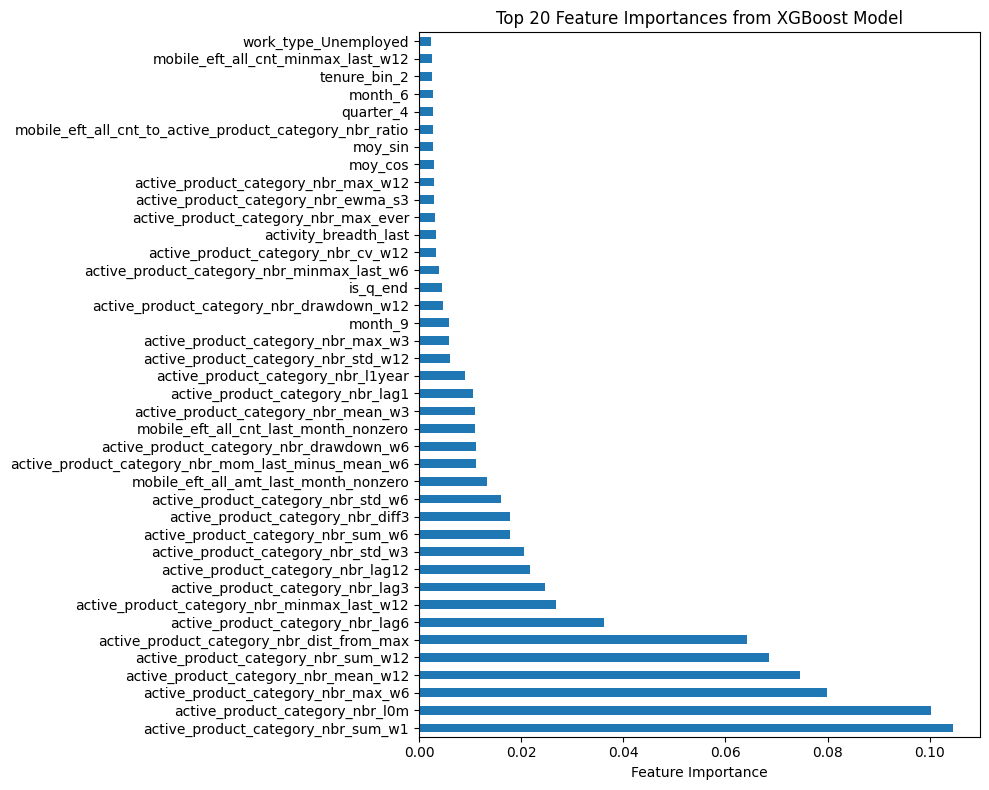

In [85]:
model.feature_importances_
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 8))
feature_importances.head(40).plot(kind='barh')
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances from XGBoost Model')
plt.tight_layout()
plt.show()

TO DO 

* optimize fonksiyonunu study fonksiyonu olarak güncelle ve parametreleri + inputları + modeli bir JSON'a yazdır, bu JSON'ı return et.
* JSON dosyalarını kullanarak tekrar train et ve modeli .pkl olarak kaydet.
* feature kısmına daha doğru düzgün odaklan. 